<a href="https://colab.research.google.com/github/szymanski52/cubism/blob/main/august3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset

In [1]:
from torchvision import transforms, datasets
import os
import zipfile
import torch.nn as nn
import gdown
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
from google.colab import files
import cv2 as cv
import numpy as np
import torch

In [2]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#files.upload()
!unzip drive/MyDrive/fashion.zip -d fashion
!rm -r fashion/__MACOSX
#!unzip gpics.zip -d gpics
#!rm -r gpics/__MACOSX

Streaming output truncated to the last 5000 lines.
  inflating: fashion/__MACOSX/fashion1024/._ae52bd43c5ef8170efb8bef7932d0da4.jpg  
  inflating: fashion/__MACOSX/fashion1024/._00b9a7729c9934f76ff67c54b5ad94f3.jpg  
  inflating: fashion/__MACOSX/fashion1024/._614f163caab359f011bda508c7148d77.jpg  
  inflating: fashion/__MACOSX/fashion1024/._af3c0e6bb7b83e0f76d0098d4f783d04.jpg  
  inflating: fashion/__MACOSX/fashion1024/._7a216b63af68d5074ad095b5e0390757.jpg  
  inflating: fashion/__MACOSX/fashion1024/._550b59a36deac489a8b4c212630679a7.jpg  
  inflating: fashion/__MACOSX/fashion1024/._2b028451ee6e7a3fdee38e02937e583b.jpg  
  inflating: fashion/__MACOSX/fashion1024/._3374f009277d4dc1d880ea064378ddfc.jpg  
  inflating: fashion/__MACOSX/fashion1024/._84f2c8c416d9cd5b5a53611e1122f6de.jpg  
  inflating: fashion/__MACOSX/fashion1024/._967cb8676b3efaa9415953885a81cbc0.jpg  
  inflating: fashion/__MACOSX/fashion1024/._a2b5a9645469306cef6808a624d8220a.jpg  
  inflating: fashion/__MACOSX/fashio

In [4]:
class CannyDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    image_names = os.listdir(root_dir)
    self.def_img = '01361d9b8bfdcc0c6801df23d60bc692.jpg'
    self.root_dir = root_dir
    self.transform = transform
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    try:
        img_path = os.path.join(self.root_dir, self.image_names[idx])
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    except:
        img_path = os.path.join(self.root_dir, self.def_img)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    canny = cv.Canny(img, 100, 150)
    canny = cv.cvtColor(canny, cv.COLOR_BGR2RGB)
    if self.transform:
        img = self.transform(Image.fromarray(img))
        canny = self.transform(Image.fromarray(canny))
    return img, canny

In [5]:
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')
# Spatial size of training images, images are resized to this size.
image_size = 256
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    #transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                      std=[0.5, 0.5, 0.5])
])
# Load the dataset from file and apply transformations
canny_dataset = CannyDataset(f'fashion/fashion1024', transform)
#canny_dataset = CannyDataset(f'gpics', transform)

# Batch size during training
batch_size = 40
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

canny_dataloader = torch.utils.data.DataLoader(canny_dataset,
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               pin_memory=pin_memory,
                                               shuffle=True,
                                               drop_last=True
                                              )

In [6]:
item = canny_dataset.__getitem__(30)
im = item[0]
target = item[1]

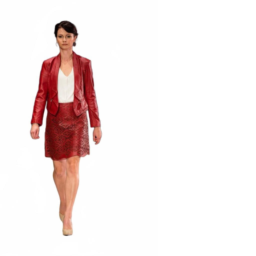

In [7]:
transforms.ToPILImage()(im)

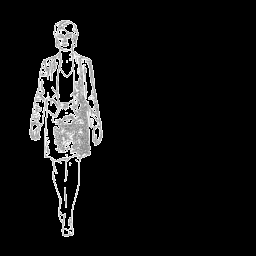

In [8]:
transforms.ToPILImage()(target*255)

#Model

In [10]:
def draw_line(c, out_size = 256, width = 1):
    e = torch.Tensor([[i for i in range(1,out_size+1)]]).to(device)
    e = e.repeat(out_size,1)
    e_x = e
    e_y = e.T
    if (c[1][1] - c[0][1]) * (c[1][0] - c[0][0]):
        kf = abs((c[1][1] - c[0][1]) / (c[1][0] - c[0][0]))
        if kf <= 1:
            if(c[1][0] < c[0][0]) and (c[1][1] < c[0][1]):
                d = width - torch.abs(e_y - (c[0][1] - c[1][1]) * (e_x - c[1][0]) / (c[0][0] - c[1][0]) - c[1][1])
                b1 = e_x - c[1][0] + 1
                b1 = torch.clamp(b1, 0, 1)
                b2 = c[0][0] - e_x + 1
                b2 = torch.clamp(b2, 0, 1)
            else:
                d = width - torch.abs(e_y - (c[1][1] - c[0][1]) * (e_x - c[0][0]) / (c[1][0] - c[0][0]) - c[0][1])
                b1 = e_x - c[0][0] + 1
                b1 = torch.clamp(b1, 0, 1)
                b2 = c[1][0] - e_x + 1
                b2 = torch.clamp(b2, 0, 1)
        else:
            if(c[1][0] < c[0][0]) and (c[1][1] < c[0][1]):
                d = width - torch.abs(e_x - (c[0][0] - c[1][0]) * (e_y - c[1][1]) / (c[0][1] - c[1][1]) - c[1][0])
                b1 = e_y - c[1][1] + 1
                b1 = torch.clamp(b1, 0, 1)
                b2 = c[0][1] - e_y + 1
                b2 = torch.clamp(b2, 0, 1)
            else:
                d = width - torch.abs(e_x - (c[1][0] - c[0][0]) * (e_y - c[0][1]) / (c[1][1] - c[0][1]) - c[0][0])
                b1 = e_y - c[0][1] + 1
                b1 = torch.clamp(b1, 0, 1)
                b2 = c[1][1] - e_y + 1
                b2 = torch.clamp(b2, 0, 1)
    elif not (c[1][0] - c[0][0]):
        d = width - torch.abs(e_x - c[0][0])
        b1 = e_y - c[1][1] + 1
        b1 = torch.clamp(b1, 0, 1)
        b2 = c[0][1] - e_y + 1
        b2 = torch.clamp(b2, 0, 1)
    else:
        d = width - torch.abs(e_y - c[1][1])
        b1 = e_x - c[0][0] + 1
        b1 = torch.clamp(b1, 0, 1)
        b2 = c[1][0] - e_x + 1
        b2 = torch.clamp(b2, 0, 1)
    if ((c[0][0] - c[1][0]) ** 2 + (c[0][1] - c[1][1]) ** 2) ** 0.5 <= 30:
        b1 += torch.ones((256, 256)).to(device)
        b2 += torch.ones((256, 256)).to(device)
    k = d * (d > 0)    
    f = k * b1 * b2
    return f

In [11]:
from torch.nn import Module
from typing import Tuple, Union
from torch import Tensor
from torch.types import _size


class Render(Module):
    __constants__ = ['out_size', 'line_w']
    out_size: int
    line_w: int

    def __init__(self, out_size: int = 256, line_w: int = 10) -> None:
        super(Render, self).__init__()
        self.out_size = out_size
        self.line_w = line_w

    def forward(self, input: Tensor) -> Tensor:
        points = input.reshape(input.shape[0],20,2,2) * self.out_size
        silhouettes = torch.Tensor().to(device)
        for k in points:
            silhouette = torch.zeros((3, self.out_size, self.out_size)).to(device)
            for l in k:
                s = draw_line(l, width=self.line_w)
                silhouette[0] += s
                silhouette[1] += s
                silhouette[2] += s
            silhouettes = torch.cat((silhouettes, silhouette))
        silhouettes = silhouettes.resize(input.shape[0], 3,
                                         self.out_size,
                                         self.out_size)  
        return silhouettes


In [12]:
class LinesGenerator(nn.Module):
    def __init__(self, lines_n):
        self.points = None
        super(LinesGenerator, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 65)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(3, 3, 65)
        self.bn2 = nn.BatchNorm2d(3)
        self.bn3 = nn.BatchNorm3d(3)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(3, 3, 79)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout2 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()


        self.fc1 = nn.Linear(7500, 5000)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)
        self.bn11 = nn.BatchNorm1d(5000)
        self.fc2 = nn.Linear(5000, 3000)
        self.relu5 = nn.LeakyReLU(0.2, inplace=True)
        self.bn12 = nn.BatchNorm1d(3000)
        self.dropout3 = nn.Dropout(0.7)

        self.fc3 = nn.Linear(3000, 1000)
        self.relu6 = nn.LeakyReLU(0.2, inplace=True)
        self.bn13 = nn.BatchNorm1d(1000)
        self.fc4 = nn.Linear(1000, 750)
        self.relu7 = nn.LeakyReLU(0.2, inplace=True)
        self.bn14 = nn.BatchNorm1d(750)
        self.dropout4 = nn.Dropout(0.9)

        self.fc5 = nn.Linear(750, 500)
        self.relu8 = nn.LeakyReLU(0.2, inplace=True)
        self.bn15 = nn.BatchNorm1d(500)
        self.fc6 = nn.Linear(500, 200)
        self.relu9 = nn.LeakyReLU(0.2, inplace=True)
        self.bn16 = nn.BatchNorm1d(200)
        self.dropout5 = nn.Dropout(0.9)

        self.fc7 = nn.Linear(200, lines_n * 4)
        self.relu10 = nn.LeakyReLU(0.2, inplace=True)
        self.bn17 = nn.BatchNorm1d(lines_n * 4)
        self.sigmoid = nn.Sigmoid()
        self.render = Render(line_w=5)

    def forward(self, X):
        x = self.conv1(X)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.bn2(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.bn11(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.bn12(x)
        x = self.dropout3(x)
        
        x = self.fc3(x)
        x = self.relu6(x)
        x = self.bn13(x)
        x = self.fc4(x)
        x = self.relu7(x)
        x = self.bn14(x)
        x = self.dropout4(x)

        x = self.fc5(x)
        x = self.relu8(x)
        x = self.bn15(x)
        x = self.fc6(x)
        x = self.relu9(x)
        x = self.bn16(x)
        x = self.dropout5(x)

        x = self.fc7(x)
        x = self.relu10(x)
        x = self.bn17(x)
        x = self.sigmoid(x)
        self.points = x * 255
        x = self.render(x)
        return x

In [13]:
model = LinesGenerator(20)
model.cuda()

LinesGenerator(
  (conv1): Conv2d(3, 3, kernel_size=(65, 65), stride=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(3, 3, kernel_size=(65, 65), stride=(1, 1))
  (bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(3, 3, kernel_size=(79, 79), stride=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=7500, out_features=5000, bias=True)
  (relu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (bn11): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=5000, out_features=3000, bias=True)
  (relu5): LeakyReLU(negative_slope=0.2, inplace=Tr

#Training

In [14]:
!pip3 install transformers
from transformers import AdamW

In [15]:
def weightedLoss(x, target, toleracy=0.3, penalty=100):
    criterion = nn.MSELoss(reduction='none')
    #a = x.clamp(0, 1e-4) * 1e+4
    #b = target.clamp(0, 1e-4) * 1e+4
    a = x
    b = target
    c = b * a
    l1 = criterion(c, b) * penalty
    d = (1 - b) * a
    l2 = criterion(d, b) * toleracy
    l = l1 + l2
    #print(l.shape)
    return l.mean()

In [16]:
from sklearn.metrics import f1_score
losses = []
def train(data):
    train_loss = 0
    train_acc = 0
    for i, (img_batch, target_batch) in enumerate(data):
        img_batch = img_batch.to(device)
        output = model(img_batch)
        optimizer.zero_grad()
        target = target_batch.to(device)
        #loss = criterion(output, target)
        loss = weightedLoss(output, target, 1.5, 100000000)
        losses.append(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    return train_loss / len(data)

In [ ]:
import time
from torch.utils.data.dataset import random_split

EPOCHS = 2
LR = 1e-3  # learning rate
  
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=LR, eps=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1e-2, gamma=1e-6)
device = torch.device('cuda:0')
 
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    loss = train(canny_dataloader)
    print('-' * 45 + str(epoch) + '-' * 45)
    print(loss)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


---------------------------------------------1---------------------------------------------
7736452.723441108


#Results

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Evaluation

In [ ]:
def check_by_index(model, index):
    item = canny_dataset.__getitem__(index)
    im = item[0]
    target = item[1]
    model.eval()
    out = model(im.to(device).unsqueeze(0))
    print(model.points)
    img = transforms.ToPILImage()(out[0])
    loss = criterion(out[0], (target).to(device))
    print(criterion._get_name(), loss)
    return img, transforms.ToPILImage()(out[0]+target.to(device)), out

In [ ]:
res = check_by_index(model, 5305)

In [ ]:
res[0]

In [ ]:
res[1]